In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sympy.combinatorics.graycode import bin_to_gray,gray_to_bin
from keras.models import load_model
import operator
import random
import numpy
import math
from deap import base
from deap import creator
from deap import tools
from sklearn.metrics import accuracy_score
import math


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
data_1 = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/data_batch_1')
x1_train = data_1[b'data']
y1_train = data_1[b'labels']
y1_train = np.array(y1_train).reshape(len(y1_train),1)
print(x1_train.shape,y1_train.shape)

data_2 = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/data_batch_2')
x2_train = data_2[b'data']
y2_train = data_2[b'labels']
y2_train = np.array(y2_train).reshape(len(y2_train),1)
print(x2_train.shape,y2_train.shape)

data_3 = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/data_batch_3')
x3_train = data_3[b'data']
y3_train = data_3[b'labels']
y3_train = np.array(y3_train).reshape(len(y3_train),1)
print(x3_train.shape,y3_train.shape)

data_4 = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/data_batch_4')
x4_train = data_4[b'data']
y4_train = data_4[b'labels']
y4_train = np.array(y4_train).reshape(len(y4_train),1)
print(x4_train.shape,y4_train.shape)

data_5 = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/data_batch_5')
x5_train = data_5[b'data']
y5_train = data_5[b'labels']
y5_train = np.array(y5_train).reshape(len(y5_train),1)
print(x5_train.shape,y5_train.shape)

data_test = unpickle('/Users/trieuhoanghiep/Downloads/cifar-10-batches-py/test_batch')
x1_test = data_test[b'data']
y1_test = data_test[b'labels']
y1_test = np.array(y1_test).reshape(len(y1_test),1)

x_test = np.zeros(shape=(10000, 32,32,3), dtype=int)
for i in range(len(x_test)):
    single_img_reshaped = np.transpose(np.reshape(x1_test[i],(3, 32,32)), (1,2,0))
    x_test[i] = single_img_reshaped

(10000, 3072) (10000, 1)
(10000, 3072) (10000, 1)
(10000, 3072) (10000, 1)
(10000, 3072) (10000, 1)
(10000, 3072) (10000, 1)


In [5]:
x_train_all = np.concatenate([x1_train, x2_train,x3_train,x4_train,x5_train])
y_train_all = np.concatenate([y1_train, y2_train,y3_train,y4_train,y5_train])
print(x_train_all.shape,y_train_all.shape)

x_train = np.zeros(shape=(50000, 32,32,3), dtype=int)
for i in range(len(x_train)):
    single_img_reshaped = np.transpose(np.reshape(x_train_all[i],(3, 32,32)), (1,2,0))
    x_train[i] = single_img_reshaped

x_train = x_train/255.0
x_test = x_test/255.0

(50000, 3072) (50000, 1)


In [6]:
model = load_model('/Users/trieuhoanghiep/Downloads/Cifar10Model1.h5')

In [7]:
def IP2bit(b):
    newInd_IP=[]
    for index in range(len(b)):
        chromosome = format(b[index], "08b")
        chromosome = bin_to_gray(chromosome)
        newInd_IP.extend(chromosome)
    #newInd_IP = bin_to_gray(newInd_IP)
    newInd_IP = [int(i) for i in newInd_IP]
    return newInd_IP

def chrom2real(c):
    numOfBits = 16
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-1+2.0*numasint/(2**numOfBits)
    return numinrange

def separatevariables(v):
#     print(v)
    numOfBits = 16
    sep = []
    for i in range (0,numOfBits*650,numOfBits):
        sep.append(chrom2real(v[i:i+numOfBits]))
    return sep

In [8]:
numOfBits = 16
Chrom_length = 650
bit = 8
posMinInit      = 1
posMaxInit      = 2**bit
VMaxInit        = 0.1*posMaxInit
VMinInit        = -0.1*posMaxInit
populationSize  = 30
dimension       = int((Chrom_length*numOfBits)/bit)
interval        = 1
iterations      = 100
xmax = 50
best_value = []
fitness_list_best = []
fitness_list_worst = []
r = 0.018
#Parameter setup

wmax = 0.9 #weighting
wmin = 0.4 
c1   = 2.0
c2   = 2.0

idx_order = y_train_all[:,0].argsort()
a = x_train[idx_order]
b = y_train_all[idx_order]

creator.create("FitnessMin", base.Fitness, weights=(1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)
# particle rerpresented by list of 5 things
# 1. fitness of the particle, 
# 2. speed of the particle which is also going to be a list, 
# 3.4. limit of the speed value, 
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(int(random.uniform(posMinInit, posMaxInit)) for _ in range(size)) 
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part, best, weight,pop):

    r1 = (random.uniform(0, 1) for _ in range(len(part)))
    r2 = (random.uniform(0, 1) for _ in range(len(part)))

    v_r0 = [weight*x for x in part.speed]
    v_r1 = [c1*x for x in map(operator.mul, r1, map(operator.sub, part.best, part))] # local best
    v_r2 = [c2*x for x in map(operator.mul, r2, map(operator.sub, best, part))] # global best
    
    part.speed = [0.7*x for x in map(operator.add, v_r0, map(operator.add, v_r1, v_r2))]

    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)

    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [1-i if i<1 else i for i in part[:]]
    part[:] = [posMaxInit - (i-posMaxInit) if i>posMaxInit else i for i in part[:]]
    part[:] = [int(i) for i in part[:]]

def loss_func(part):
    new_pop = IP2bit(part)
    layer_weights = separatevariables(new_pop)

    weights = np.array(layer_weights[0:640]).reshape(64,10)
    bias = np.array(layer_weights[640:]).reshape(10,)
    layer_weights = [weights,bias]
    model.layers[-1].set_weights(layer_weights)

    a1 = random.sample(range(0, 5000), 100)
    part_x_train_1 = np.array([a[x] for x in a1])
    part_y_train_1 = np.array([b[x] for x in a1])

    a2 = random.sample(range(5000, 10000), 100)
    part_x_train_2 = np.array([a[x] for x in a2])
    part_y_train_2 = np.array([b[x] for x in a2])

    a3 = random.sample(range(10000, 15000), 100)
    part_x_train_3 = np.array([a[x] for x in a3])
    part_y_train_3 = np.array([b[x] for x in a3])

    a4 = random.sample(range(15000, 20000), 100)
    part_x_train_4 = np.array([a[x] for x in a4])
    part_y_train_4 = np.array([b[x] for x in a4])

    a5 = random.sample(range(20000, 25000), 100)
    part_x_train_5 = np.array([a[x] for x in a5])
    part_y_train_5 = np.array([b[x] for x in a5])

    a6 = random.sample(range(25000, 30000), 100)
    part_x_train_6 = np.array([a[x] for x in a6])
    part_y_train_6 = np.array([b[x] for x in a6])

    a7 = random.sample(range(30000, 35000), 100)
    part_x_train_7 = np.array([a[x] for x in a7])
    part_y_train_7 = np.array([b[x] for x in a7])

    a8 = random.sample(range(35000, 40000), 100)
    part_x_train_8 = np.array([a[x] for x in a8])
    part_y_train_8 = np.array([b[x] for x in a8])

    a9 = random.sample(range(40000, 45000), 100)
    part_x_train_9 = np.array([a[x] for x in a9])
    part_y_train_9 = np.array([b[x] for x in a9])

    a10 = random.sample(range(45000, 50000), 100)
    part_x_train_10 = np.array([a[x] for x in a10])
    part_y_train_10 = np.array([b[x] for x in a10])

    x_train_pred = np.concatenate([part_x_train_1, part_x_train_2,part_x_train_3,part_x_train_4,part_x_train_5,part_x_train_6,part_x_train_7,part_x_train_8,part_x_train_9,part_x_train_10])
    y_train_pred = np.concatenate([part_y_train_1, part_y_train_2,part_y_train_3,part_y_train_4,part_y_train_5,part_y_train_6,part_y_train_7,part_y_train_8,part_y_train_9,part_y_train_10])

    y_pred = model.predict(x_train_pred,verbose = 0)
    y_pred_classes = [np.argmax(element) for element in y_pred]
    loss = accuracy_score(y_train_pred,y_pred_classes)
    return loss,

def generate_new(pop):
    sorted_pop = sorted(pop, key=lambda ind: ind.fitness.values, reverse=True)
    l = [sorted_pop[0], sorted_pop[1],sorted_pop[2],sorted_pop[3],sorted_pop[4]]
    new_par = [(a+b+c+d+e)//5 for a,b,c,d,e in zip(*l)]

    l_speed = [sorted_pop[0].speed, sorted_pop[1].speed,sorted_pop[2].speed,sorted_pop[3].speed,sorted_pop[4].speed]
    new_par_speed = [(a+b+c+d+e)/5 for a,b,c,d,e in zip(*l_speed)]

    part1 = creator.Particle(new_par) 
    part1.speed = new_par_speed
    part1.smin = -0.1*posMaxInit #speed clamping values
    part1.smax = 0.1*posMaxInit
    return part1

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-0.1*posMaxInit, smax=0.1*posMaxInit)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)
toolbox.register("evaluate", loss_func) 
toolbox.register("particle_new", generate_new)

def main():
    pop = toolbox.population(n=populationSize) # Population Size
    
    for part in pop:
        index = pop.index(part)
        keys = list(range(1,dimension+1))
        globals()['dictionary%s' % index] = dict(zip(keys, pop[index]))

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None

    #begin main loop
    for g in range(iterations):
        w = wmax - (wmax-wmin)*g/iterations #decaying inertia weight
        for part in pop:
            part.fitness.values = toolbox.evaluate(part) #actually only one fitness value
        
            #update local best
            if (not part.best) or (part.best.fitness < part.fitness):   #lower fitness is better (minimising)
            #   best is None   or  current value is better              #< is overloaded        
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            
            #update global best
            if (not best) or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
                print(best.fitness.values[0])

                new_pop = IP2bit(best)
                layer_weights = separatevariables(new_pop)

                weights = np.array(layer_weights[0:640]).reshape(64,10)
                bias = np.array(layer_weights[640:]).reshape(10,)
                layer_weights = [weights,bias]
                model.layers[-1].set_weights(layer_weights)

                y_pred = model.predict(x_test,verbose = 0)
                y_pred_classes = [np.argmax(element) for element in y_pred]
                loss = accuracy_score(y1_test,y_pred_classes)
                print(loss)
        for part in pop:
            toolbox.update(part, best,w,pop)

        sorted_pop = sorted(pop, key=lambda ind: ind.fitness.values, reverse=True)
        fitness_list_best.append(sorted_pop[0].fitness.values[0])
        fitness_list_worst.append(sorted_pop[-1].fitness.values[0])
        # Gather all the fitnesses in one list and print the stats
        x0 = populationSize
        growth_pop = xmax/(1+(xmax/x0-1)*(math.exp(-r*g)))
        if growth_pop - len(pop) >=1:
            particle = toolbox.particle_new(pop)
            particle.fitness.values = toolbox.evaluate(particle)
            pop.append(particle)

        if g%interval==0: # interval 
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
            #print('best ',best, best.fitness)
    
    print('best particle position is ',best)
    print(best.fitness)
    best_value.extend(best)
    return pop, logbook, best,best_value,fitness_list_best,fitness_list_worst

if __name__ == "__main__":
    main()


0.024
0.0356
0.143
0.1275
0.152
0.1678
0.173
0.1565
gen	evals	avg      	std      	min  	max  
0  	30   	0.0796667	0.0458144	0.003	0.173
0.209
0.1943
1  	30   	0.0883   	0.0441083	0.012	0.209
0.226
0.2082
2  	30   	0.107133 	0.0481378	0.008	0.226
0.266
0.2437
0.299
0.2721
3  	30   	0.143467 	0.0571114	0.034	0.299
4  	30   	0.1713   	0.0555495	0.082	0.272
5  	31   	0.205677 	0.0586638	0.094	0.311
0.336
0.305
6  	31   	0.242194 	0.0486498	0.114	0.336
0.343
0.3095
0.346
0.3101
0.347
0.3021
7  	31   	0.288548 	0.0445876	0.107	0.347
0.37
0.3199
8  	31   	0.306323 	0.0382676	0.133	0.37 
0.393
0.3451
9  	31   	0.350581 	0.0423745	0.136	0.393
0.394
0.3467
0.402
0.3382
0.405
0.3469
0.407
0.3391
10 	32   	0.375219 	0.0368686	0.188	0.407
0.411
0.348
11 	32   	0.381875 	0.0356386	0.203	0.411
0.414
0.3467
0.419
0.3552
0.425
0.3508
0.43
0.3579
12 	32   	0.392969 	0.0303444	0.248	0.43 
0.435
0.3636
13 	32   	0.405469 	0.0170971	0.352	0.435
0.437
0.3774
0.442
0.3685
14 	32   	0.4185   	0.012515 	0.39 	

In [9]:
y_pred = model.predict(x_train,verbose = 0)
y_pred_classes = [np.argmax(element) for element in y_pred]
loss = accuracy_score(y_train_all,y_pred_classes)
loss

0.52252

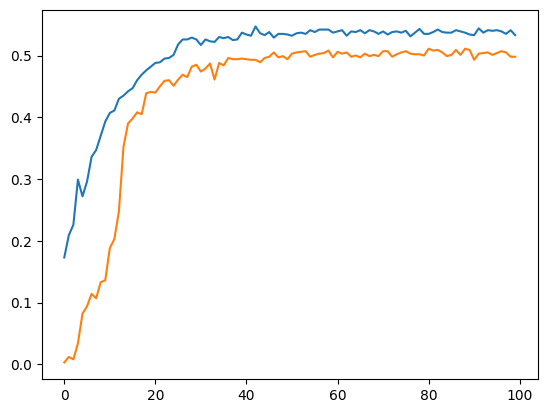

In [10]:
plt.plot(fitness_list_best)
plt.plot(fitness_list_worst)

In [11]:
new_pop = IP2bit(best_value)
layer_weights = separatevariables(new_pop)
weights = np.array(layer_weights[0:640]).reshape(64,10)
bias = np.array(layer_weights[640:]).reshape(10,)
layer_weights = [weights,bias]
model.layers[-1].set_weights(layer_weights)

y_pred = model.predict(x_test,verbose = 0)
y_pred_classes = [np.argmax(element) for element in y_pred]
loss = accuracy_score(y1_test,y_pred_classes)
loss

0.4265